In [1]:
import sys
sys.path.append('../src/')
import os
import re
import nibabel as nib
import numpy as np
import scipy
import math

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

from finetune_3D import *
from logistic_regression import *
from models import *
from utils import *

In [3]:
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/WMD/n=414_random_state=3001.csv')
print(open('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/WMD/n=414_random_state=3001.txt').read())
df.tail()

{'seed': 1001, 'lr': 0.01, 'wd1': 0.0001}



,epoch,train_loss,train_BA,train_auroc,val_loss,val_BA,val_auroc,test_loss,test_BA,test_auroc
995,996,0.582427,[0.82620968],[0.8933933],0.784805,[0.66136364],[0.66515152],0.671489,[0.72878788],[0.81212121]
996,997,0.582426,[0.82459677],[0.89330025],0.784954,[0.66515152],[0.66818182],0.673878,[0.66515152],[0.81212121]
997,998,0.582698,[0.82459677],[0.89314516],0.785502,[0.65378788],[0.66363636],0.670174,[0.66515152],[0.81212121]
998,999,0.582267,[0.82459677],[0.8933933],0.784955,[0.66136364],[0.66666667],0.671628,[0.72878788],[0.81212121]
999,1000,0.582911,[0.82459677],[0.89413772],0.785213,[0.66515152],[0.67272727],0.677079,[0.66515152],[0.81060606]


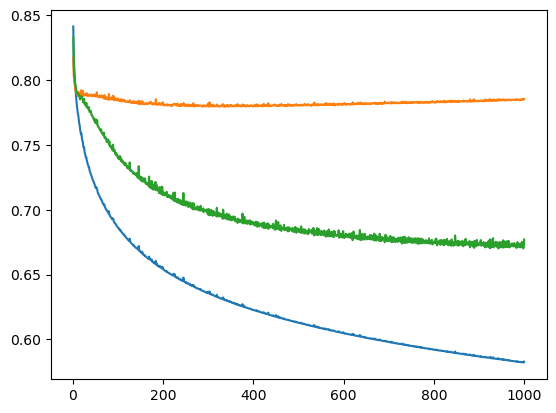

In [4]:
plt.plot(df.epoch.to_list(), df.train_loss.to_list())
plt.plot(df.epoch.to_list(), df.val_loss.to_list())
plt.plot(df.epoch.to_list(), df.test_loss.to_list())

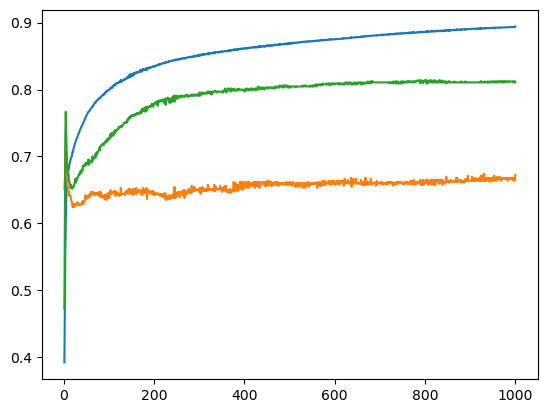

In [5]:
plt.plot(df.epoch.to_list(), np.array(df.train_auroc.to_list())[:,0])
plt.plot(df.epoch.to_list(), np.array(df.val_auroc.to_list())[:,0])
plt.plot(df.epoch.to_list(), np.array(df.test_auroc.to_list())[:,0])

In [6]:
val_performance = np.array(df.val_loss.to_list())
averaged_performance = np.array([sum(val_performance[index-30:index]) for index in range(30, len(val_performance))])
print(val_performance.shape)
print('best epoch: {}'.format(30+np.argmin(averaged_performance)))
print('val_auroc: {}'.format(df.val_auroc.to_list()[30+np.argmin(averaged_performance)]))
print('test_auroc: {}'.format(df.test_auroc.to_list()[30+np.argmin(averaged_performance)]))

(1000,)
best epoch: 350
val_auroc: [0.6469697]
test_auroc: [0.7969697]


In [11]:
columns = ['n', 'random_state', 'train_BA', 'train_auroc', 'val_BA', 'val_auroc', 'test_BA', 'test_auroc']
df = pd.DataFrame(columns=columns)

ns = [60, 94, 147, 230, 360, 414, 475, 546, 627]
ns = [60, 94, 147, 230, 360, 414, 475]
random_states = [1001, 2001, 3001, 4001, 5001, 6001, 7001, 8001, 9001, 10001, 11001, 12001, 13001, 14001, 15001]
experiments_path = '/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/WMD'

for model_index, (n, random_state) in enumerate(itertools.product(ns, random_states)):    
    temp_df = load_experiment('{}/n={}_random_state={}.csv'\
                         .format(experiments_path, n, random_state))
    val_performance = np.array(temp_df.val_auroc.to_list())
    averaged_performance = np.array([sum(val_performance[index-30:index]) for index in range(30, len(val_performance))])
    #averaged_performance[np.all(np.array(temp_df.train_auroc.to_list())[30:] < val_performance[30:], axis=-1)] = 0
    train_loss, train_BA, train_auroc, val_loss, val_BA, val_auroc, test_loss, test_BA, test_auroc = temp_df.iloc[30+np.argmax(averaged_performance)].to_list()[1:]
    row = [n, random_state, train_BA, train_auroc, val_BA, val_auroc, test_BA, test_auroc]
    df.loc[model_index] = row
    print('best epoch: {}'.format(30+np.argmax(averaged_performance)))
    print('val_loss: {:0.4f}'.format(temp_df.val_loss.to_list()[30+np.argmax(averaged_performance)]))
    print(open('{}/n={}_random_state={}.txt'.format(experiments_path, n, random_state)).read())

best epoch: 940
val_loss: 0.7866
{'seed': 1001, 'lr': 0.01, 'wd1': 0.001}

best epoch: 49
val_loss: 0.7816
{'seed': 1001, 'lr': 0.01, 'wd1': 0.1}

best epoch: 93
val_loss: 0.7989
{'seed': 1001, 'lr': 0.01, 'wd1': 0.0}

best epoch: 112
val_loss: 0.7800
{'seed': 1001, 'lr': 0.01, 'wd1': 0.1}

best epoch: 922
val_loss: 0.7142
{'seed': 1001, 'lr': 0.01, 'wd1': 0.01}

best epoch: 552
val_loss: 0.7941
{'seed': 1001, 'lr': 0.01, 'wd1': 0.1}

best epoch: 946
val_loss: 0.7526
{'seed': 1001, 'lr': 0.01, 'wd1': 0.0}

best epoch: 999
val_loss: 0.7122
{'seed': 1001, 'lr': 0.01, 'wd1': 0.001}

best epoch: 37
val_loss: 0.8329
{'seed': 1001, 'lr': 0.01, 'wd1': 1.0}

best epoch: 999
val_loss: 0.7247
{'seed': 1001, 'lr': 0.01, 'wd1': 0.01}

best epoch: 603
val_loss: 0.6982
{'seed': 1001, 'lr': 0.01, 'wd1': 0.0001}

best epoch: 34
val_loss: 0.8162
{'seed': 1001, 'lr': 0.01, 'wd1': 1.0}

best epoch: 919
val_loss: 0.8414
{'seed': 1001, 'lr': 0.01, 'wd1': 0.01}

best epoch: 30
val_loss: 0.8201
{'seed': 1001

In [12]:
df

,n,random_state,train_BA,train_auroc,val_BA,val_auroc,test_BA,test_auroc
0,60,1001,[1.0],[1.0],[0.73030303],[0.68787879],[0.58560606],[0.67575758]
1,60,2001,[0.91111111],[0.92444444],[0.66212121],[0.64848485],[0.53863636],[0.60151515]
2,60,3001,[0.88492063],[0.90873016],[0.67348485],[0.63333333],[0.66212121],[0.65909091]
3,60,4001,[0.85714286],[0.93322981],[0.65],[0.65151515],[0.41590909],[0.41818182]
4,60,5001,[1.0],[1.0],[0.76363636],[0.73939394],[0.56060606],[0.62727273]
...,...,...,...,...,...,...,...,...
100,475,11001,[0.81010948],[0.88326866],[0.80681818],[0.85909091],[0.68409091],[0.8030303]
101,475,12001,[0.78819396],[0.86688145],[0.64015152],[0.63333333],[0.74166667],[0.82878788]
102,475,13001,[0.76560396],[0.84029165],[0.70984848],[0.75454545],[0.62121212],[0.70151515]
103,475,14001,[0.80734222],[0.88199508],[0.78712121],[0.76818182],[0.65227273],[0.74545455]


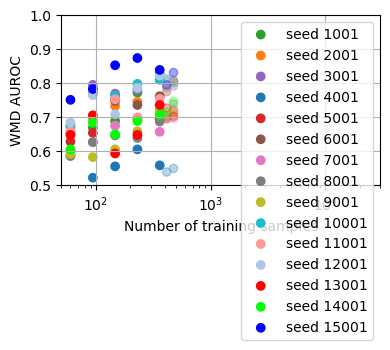

In [13]:
def get_alpha(n):
    if n <= 360:
        return 1.0
    else:
        return 0.3

def plot_experiment(df, labels, random_states=[1001, 2001, 3001]):
    df = df[df.random_state.isin(random_states)]
    colors = ['#2ca02c', '#ff7f0e', '#9467bd', '#1f77b4', '#d62728', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff9896', '#aec7e8', '#ff0000', '#00ff00', '#0000ff']
    ncols = len(labels) if len(labels) < 4 else 4
    nrows = math.ceil(len(labels)/4)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
    for label_index, _ in enumerate(labels):       
        for color, random_state in zip(colors, random_states):
            # Plot data
            temp_df = df[df.random_state==random_state]
            np.array(axs).flatten()[label_index]\
            .scatter(temp_df.n.to_numpy(),
                     np.array(temp_df.test_auroc.to_list())[:,label_index],
                     color = color,
                     alpha=list(map(get_alpha, df.n[df.random_state==random_state].to_list())),
                     label='seed {}'.format(random_state))
        np.array(axs).flatten()[label_index]\
        .set_xlim([50, 30000])
        np.array(axs).flatten()[label_index]\
        .set_ylim([0.5, 1.0])
        np.array(axs).flatten()[label_index]\
        .set_xscale('log')
        np.array(axs).flatten()[label_index]\
        .set_xlabel('Number of training samples')
        np.array(axs).flatten()[label_index]\
        .set_ylabel('{} AUROC'.format(labels[label_index]))
        np.array(axs).flatten()[label_index]\
        .legend()
        np.array(axs).flatten()[label_index]\
        .grid()
    fig.tight_layout()
    plt.show()
    
plot_experiment(df, ['WMD'], random_states)

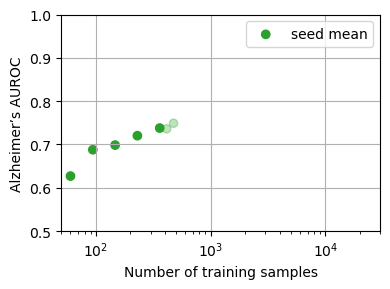

In [14]:
df = df.groupby('n').agg(lambda x: list(x))
df.test_auroc = df.test_auroc.apply(lambda x: np.array([np.mean(x)]))
df.random_state = df.random_state.apply(lambda x: 'mean')
df = df.reset_index()
plot_experiment(df, ['Alzheimer’s'], ['mean'])